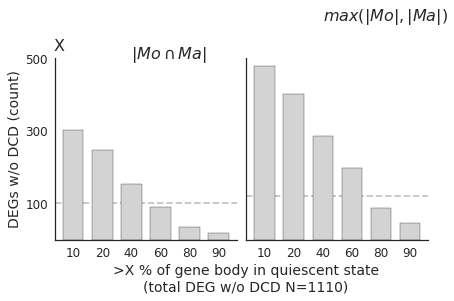

In [2]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import time as ti
import json as js

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
from pandas.errors import EmptyDataError
import seaborn as sns

# What does this do?
# Plot observed state configuration
# for DE genes not hit by an HSP

### THIS FILE IS NEEDED TO CACHE DATA
### FOR OTHER NOTEBOOKS

date = '20180921'

run_plot_deg_state_conf = True
save_figures = False

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['penem', 'ordem', 'penrep', 'ordrep']
segmentations = ['cmm18', 'ecs18', 'ecs10']
cmm_state_colors = '/home/pebert/work/code/mpggit/statediff/annotation/chromhmm_18/colormap_18_core_K27ac.tab'

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
sciddo_deep_dir = os.path.join(fhgfs_base, 'sciddo', 'deep')
gene_file = os.path.join(fhgfs_base, 'references', 'gencode_v21_pcg_bglist.bed')

cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')


base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')


# def plot_state_matrix(s1_states, s2_states, s1, s2, fkey):
#     """
#     """
    
#     fig, (ax_col, ax_1, ax_2) = plt.subplots(figsize=fig_sizes['two_col']['half'],
#                                              nrows=1, ncols=3, sharex=False, sharey=True,
#                                              gridspec_kw={'width_ratios': [1, 6, 6]})
    
#     plt.subplots_adjust(wspace=0.05)
    
#     colors = pd.read_csv(cmm_state_colors, sep='\t', header=None,
#                          names=['state', 'rgb'])
#     color_mat = np.zeros((colors.shape[0] + 1, 1, 3), dtype=np.uint8)
#     for row in colors.itertuples():
#         r, g, b = row.rgb.split(',')
#         color_mat[row.Index, 0, 0] = int(r)
#         color_mat[row.Index, 0, 1] = int(g)
#         color_mat[row.Index, 0, 2] = int(b)
    
#     ax_col.imshow(color_mat)
#     ax_col.set_xticks([])
#     ax_col.set_yticks([])
#     ax_col.set_ylabel('Chromatin states', fontsize=14)
       
#     s1_states.index = s1_states.index - 1
#     s2_states.index = s2_states.index - 1
    
#     ax_1.boxplot(s1_states, positions=range(0, 18), vert=False)
        
#     ax_1.set_xticks([0.25, 0.5, 0.75])
#     ax_1.set_xticklabels(['25', '50', '75'], fontsize=12)
#     ax_1.set_yticks([])
#     ax_1.set_xlabel('State coverage (%)', fontsize=14)
#     ax_1.set_xlim(-0.01, 1)
#     ax_1.spines['top'].set_visible(False)
#     ax_1.spines['right'].set_visible(False)
#     ax_1.set_title('DEG w/o HSP: {}'.format(s1), fontsize=14)
    
#     ax_2.boxplot(s2_states, positions=range(0, 18), vert=False)
#     ax_2.set_xticks([0.25, 0.5, 0.75])
#     ax_2.set_xticklabels(['25', '50', '75'], fontsize=12)
#     ax_2.set_yticks([])
#     ax_2.set_xlabel('State coverage (%)', fontsize=14)
#     ax_2.set_ylim(-0.5, 17.5)
#     ax_2.set_xlim(-0.01, 1)
#     ax_2.spines['top'].set_visible(False)
#     ax_2.spines['right'].set_visible(False)
#     ax_2.set_title('DEG w/o HSP: {}'.format(s2), fontsize=14)
    
    
#     plt.gca().invert_yaxis()
#     return fig, []


def extract_genes(gene_hits, annotation):
    
    select1 = np.logical_and(gene_hits['body_hit'] == 0, gene_hits['is_de'] == 1)
    select2 = np.logical_and(gene_hits['prom_hit'] == 0, gene_hits['total_hits'] == 0)
    select = np.logical_and(select1, select2)
    
    subset = gene_hits.loc[select, :].copy()
    
    loc = annotation.loc[annotation['name'].isin(subset.index), ['chrom', 'start', 'end', 'name']]
    loc.index = loc['name']
    loc.drop(['name'], axis=1, inplace=True)
    subset = subset.merge(loc, how='outer', left_index=True, right_index=True)
    
    subset['start_bin'] = subset['start'] // 200 * 200
    subset['end_bin'] = subset['end'] // 200 * 200 + 200
    subset.sort_values(['chrom', 'start'], inplace=True)
    subset['name'] = subset.index
    subset.reset_index(drop=True, inplace=True)
        
    return subset


def get_sample_groups(dataset, c1, c2):
    group1, group2 = set(), set()
    with pd.HDFStore(dataset, 'r') as hdf:
        samples = hdf['/metadata/inputs']
        for row in samples.itertuples():
            if c1 in row.Index:
                group1.add(row.Index)
            if c2 in row.Index:
                group2.add(row.Index)
    return group1, group2


def load_chrom_states(dataset, chrom, samples1, samples2):
    cache = dict()
    with pd.HDFStore(dataset, 'r') as hdf:
        for s in itt.chain(samples1, samples2):
            cache[s] = hdf['/state/{}/{}'.format(s, chrom)]
    return cache


def get_dataset(seg):
    p = os.path.join(fhgfs_base, 'sciddo', 'deep', '{}', 'sciddo-data_hg38_{}.h5')
    p = p.format(seg, seg)
    assert os.path.isfile(p), 'Dataset path invalid: {}'.format(p)
    return p


def collect_deg_states(cache_file, ext_cache):
    
    gene_ann = pd.read_csv(gene_file, header=0, delimiter='\t')
    gene_ann.columns = ['chrom'] + gene_ann.columns[1:].tolist() 
    
    with pd.HDFStore(ext_cache, 'r') as ext:
        for k in ext.keys():
            _, seg, score, comp = k.split('/')
            c1, c2 = comp.split('_vs_')
            if seg != 'cmm18':
                continue
            if score != 'penem':
                continue
            deg = extract_genes(ext[k], gene_ann)
            dset = get_dataset(seg)
            
            g1, g2 = get_sample_groups(dset, c1, c2)
            state_conf = {c1: col.defaultdict(col.Counter),
                          c2: col.defaultdict(col.Counter)}
            for chrom in deg['chrom'].unique(): 
                state_cache = load_chrom_states(dset, chrom, g1, g2)
                sub_deg = deg.loc[deg['chrom'] == chrom, :]
                for s1, s2 in itt.product(g1, g2):
                    states1 = state_cache[s1]
                    states2 = state_cache[s2]

                    for gene in sub_deg.itertuples():
                        conf = col.Counter(states1.loc[gene.start_bin:gene.end_bin])
                        state_conf[c1][gene.name].update(conf)

                        conf = col.Counter(states2.loc[gene.start_bin:gene.end_bin])
                        state_conf[c2][gene.name].update(conf)                               
                                    
                
                # collected all state switches
                # for this dataset
                num_states = int(seg[3:])
                # states cell type 1
                df_c1 = pd.DataFrame.from_records([state_conf[c1][k] for k in sorted(state_conf[c1].keys())],
                                                  columns=range(1, num_states + 1),
                                                  index=sorted(state_conf[c1].keys()))
                df_c1.fillna(0, inplace=True)
                df_c1 = df_c1.div(df_c1.sum(axis=1), axis=0)
                assert np.allclose(df_c1.sum(axis=1), 1, atol=1e-6), 'wrong'
                df_c1.sort_values([18, 13, 12], axis=0, ascending=False, inplace=True)
                               
                # states cell type 2
                df_c2 = pd.DataFrame.from_records([state_conf[c2][k] for k in sorted(state_conf[c2].keys())],
                                                  columns=range(1, num_states + 1),
                                                  index=sorted(state_conf[c2].keys()))
                
                # this must be identical
                assert (df_c1.index.sort_values() == df_c2.index.sort_values()).all(), 'Index mismatch'
                
                df_c2.fillna(0, inplace=True)
                df_c2 = df_c2.div(df_c2.sum(axis=1), axis=0)
                assert np.allclose(df_c2.sum(axis=1), 1, atol=1e-6), 'wrong'
                df_c2 = df_c2.loc[df_c1.index, :]
                
                cache_path = os.path.join(seg, score, comp)
                with pd.HDFStore(cache_file, 'a') as cache:
                    cache.put(os.path.join(cache_path, c1), df_c1, format='fixed')
                    cache.put(os.path.join(cache_path, c2), df_c2, format='fixed')
    return cache_file


def plot_quiet_dist(s1, s2, smp1, smp2, fkey):
    
    fig, (ax_1, ax_2) = plt.subplots(figsize=fig_sizes['two_col']['half'],
                                     nrows=1, ncols=2, sharex=True, sharey=True,
                                     gridspec_kw={'width_ratios': [1, 1]})
    
    plt.subplots_adjust(wspace=0.05)
    x_pos = [1, 2, 3, 4, 5, 6]
    
    limits = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]
    joined_bars = []
    max_bars = []
    for l in limits:
        sub1 = set(s1.loc[s1[18] > l, :].index)
        sub2 = set(s2.loc[s2[18] > l, :].index)
        isect = len(sub1.intersection(sub2))
        joined_bars.append(isect)
        max_bars.append(max(len(sub1), len(sub2)))
                
    ax_1.bar(x_pos, joined_bars, color='lightgrey', edgecolor='black',
             align='center', width=0.7)
    
    ax_2.bar(x_pos, max_bars, color='lightgrey', edgecolor='black',
             align='center', width=0.7)
    
    ax_1.spines['top'].set_visible(False)
    ax_1.spines['right'].set_visible(False)
    ax_1.axhline(100, 0, 1, color='darkgrey', alpha=0.7, ls='dashed', zorder=0)
    yticks = [100, 300, 500]
    ax_1.set_yticks(yticks)
    ax_1.set_yticklabels(map(str, yticks), fontsize=12)
    ax_1.set_ylabel('DEGs w/o DCD (count)'.format(s1.shape[0]), fontsize=14)
    ax_1.set_xticklabels(['10', '20', '40', '60', '80', '90'], fontsize=12)
    
    ax_1.text(3, 500, r'$\vert {} \cap {} \vert$'.format(smp1, smp2),
              fontsize=16)
    tt = ax_1.set_title(fkey, fontsize=16)
    tt.set_position((0.025, 1.01))
    
    ax_2.spines['top'].set_visible(False)
    ax_2.spines['right'].set_visible(False)
    ax_2.axhline(100, 0, 1, color='darkgrey', alpha=0.7, ls='dashed', zorder=0)
    
    ax_2.set_xticks(x_pos)
    ax_2.set_xticklabels(['10', '20', '40', '60', '80', '90'], fontsize=12)
    
    ax_2.text(3, 500, r'$max(\vert {} \vert , \vert {} \vert)$'.format(smp1, smp2),
              fontsize=16)
    
    tt = ax_2.set_xlabel('>X % of gene body in quiescent state' \
                         '\n(total DEG w/o DCD N={})'.format(s1.shape[0]), fontsize=14)
    tt.set_position((0., -0.025))

    return fig, []


def plot_deg_hsp_transitions():
    ext_cache = os.path.join(cache_dir, '{}_plot_gene-enh-hsp_tpm-bin.h5'.format(date))
    assert os.path.isfile(ext_cache), 'External cache file {} does not exist'.format(ext_cache)
    
    cache_file = os.path.join(cache_dir, '{}_plot_deg_state_conf.h5'.format(date))
    if not os.path.isfile(cache_file):
        cache_file = collect_deg_states(cache_file, ext_cache)
    
    with pd.HDFStore(cache_file, 'r') as hdf:
        cached_keys = list(hdf.keys())
        cached_comp = set([k.split('/')[3] for k in cached_keys])
        for seg in segmentations:
            if seg != 'cmm18':
                continue
            for scoring in scorings:
                if scoring != 'penem':
                    continue
                for comp in cached_comp:
                    if comp != 'Mo_vs_Ma':
                        continue
                    s1, s2 = comp.split('_vs_')
                    root_path = os.path.join(seg, scoring, comp)
                    # by construction, these are already sorted
                    s1_states = hdf[os.path.join(root_path, s1)]
                    s2_states = hdf[os.path.join(root_path, s2)]
                    
                    fig, exart = plot_quiet_dist(s1_states,
                                                 s2_states,
                                                 s1, s2, 'X')
                    
                    if save_figures:
                        outname = 'fig_X_deg_state-conf_{}_{}_{}'.format(seg, scoring, comp)
                        outfolder = fig_main
                        
                        out_pdf = os.path.join(outfolder, outname + '.pdf')
                        fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
                        out_png = os.path.join(outfolder, outname + '.png')
                        fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
    return 0

if run_plot_deg_state_conf:
    plot_deg_hsp_transitions()